In [1]:
!trash-empty

In [2]:
!nvidia-smi

Tue Sep 24 03:47:40 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    60W / 300W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:00:05.0 Off |                    0 |
| N/A   43C    P0    59W / 300W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
from radam import RAdam, PlainRAdam, AdamW
from am_softmax import AMSoftmaxLoss, AngleSimpleLinear

In [4]:
import os
import gc
import numpy as np 
import pandas as pd
from PIL import Image
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.utils.data as D
from torch.optim.lr_scheduler import ExponentialLR
from torchvision import models, transforms as T
import torch.nn.functional as F

import pretrainedmodels

import cv2
import fastai
from fastai.vision import *
from fastai.callbacks.tracker import SaveModelCallback

import warnings
warnings.filterwarnings('ignore')

## Config

In [5]:
config = {
    'SEED': 42,
    'CLASSES': 1108,
    'PATH_DATA': '/home/tienen/kaggle_dataset_drugs/',
    'PATH_WEIGHTS': '/home/jupyter/Nikita/',
    'DEVICE': 'cuda',
    'BATCH_SIZE': 32,
    'VAL_SIZE': 0.05,
    'MODEL_NAME': 'SeResNext',
    'USE_ANGULAR': True,
    'USE_BN': False,
    'LR': 1e-4,
    'LR_STR': '1e-4',
    'TURN_OFF_ON_N_EPOCHS': 1,
}

In [6]:
def seed_torch(seed=42):
    import random; import os
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_torch(config['SEED'])

In [7]:
#lazy calculation of stats
pixel_stats = pd.read_csv(config['PATH_DATA']+'pixel_stats.csv')
channel1_mean = pixel_stats.iloc[::6,:]['mean'].mean()
channel2_mean = pixel_stats.iloc[1::6,:]['mean'].mean()
channel3_mean = pixel_stats.iloc[2::6,:]['mean'].mean()
channel4_mean = pixel_stats.iloc[3::6,:]['mean'].mean()
channel5_mean = pixel_stats.iloc[4::6,:]['mean'].mean()
channel6_mean = pixel_stats.iloc[5::6,:]['mean'].mean()


channel1_std = pixel_stats.iloc[::6,:]['std'].mean()
channel2_std = pixel_stats.iloc[1::6,:]['std'].mean()
channel3_std = pixel_stats.iloc[2::6,:]['std'].mean()
channel4_std = pixel_stats.iloc[3::6,:]['std'].mean()
channel5_std = pixel_stats.iloc[4::6,:]['std'].mean()
channel6_std = pixel_stats.iloc[5::6,:]['std'].mean()
stats = (torch.Tensor([channel1_mean,channel2_mean,channel3_mean,channel4_mean,channel5_mean,channel6_mean])/255,torch.Tensor([channel1_std,channel2_std,channel3_std,channel4_std,channel5_std,channel6_std])/255)
print(stats)

(tensor([0.0229, 0.0611, 0.0396, 0.0391, 0.0219, 0.0356]), tensor([0.0271, 0.0492, 0.0219, 0.0292, 0.0183, 0.0193]))


In [8]:
def open_rcic_image(fn):
    images = []
    for i in range(6):
        file_name = fn+str(i+1)+'.png'
        im = cv2.imread(file_name)
        im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
        images.append(im)
    image = np.dstack(images)
    #print(pil2tensor(image, np.float32).shape)#.div_(255).shape)
    return Image(pil2tensor(image, np.float32).div_(255))
  
class MultiChannelImageList(ImageList):
    def open(self, fn):
        return open_rcic_image(fn)

## Data

In [9]:
df = pd.read_csv(config['PATH_DATA']+'/train.csv')
df_test = pd.read_csv(config['PATH_DATA']+'/test.csv')

df['category'] = df['experiment'].apply(lambda x: x.split('-')[0])
df_test['category'] = df_test['experiment'].apply(lambda x: x.split('-')[0])

In [10]:
def generate_df(train_df, site):
    train_df['path'] = train_df['experiment'].str.cat(train_df['plate'].astype(str).str.cat(train_df['well'],sep='/'),sep='/Plate') + '_s'+str(site) + '_w'
    train_df = train_df.drop(columns=['id_code','experiment','plate','well']).reindex(columns=['path','sirna'])
    return train_df

## Model

In [11]:
def seresnext(num_classes=1000, num_channels=6, pretrained=True, use_bn=True, use_angular=False):
    if pretrained:
        preloaded = pretrainedmodels.se_resnext101_32x4d(num_classes=1000, pretrained='imagenet')
    else:
        preloaded = pretrainedmodels.se_resnext101_32x4d(num_classes=1000, pretrained=None)
    #print(preloaded)
    
    if use_bn:
        preloaded = nn.Sequential(OrderedDict([
                        ('norm0', nn.BatchNorm2d(6)),
                        ('model', preloaded)
        ]))
        model = preloaded.model
    else:
        model = preloaded
    
    trained_kernel = model.layer0.conv1.weight
    new_conv = nn.Sequential(nn.Conv2d(num_channels, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False))
    with torch.no_grad():
        new_conv[0].weight[:,:] = torch.stack([torch.mean(trained_kernel, 1)]*6, dim=1)
    model.layer0.conv1 = new_conv
    
    if use_angular:
        fc_input_features = model.last_linear.in_features
        model.last_linear = AngleSimpleLinear(fc_input_features*100, num_classes)
    else:
        fc_input_features = model.last_linear.in_features
        model.last_linear = nn.Linear(fc_input_features, num_classes, bias=True)
    
    return preloaded

## Training on each category


CURRENT CATEGORY: HEPG2
----------------------------------------
last_linear is unfrozen


epoch,train_loss,valid_loss,accuracy,time
0,15.673158,16.223583,0.378065,09:29


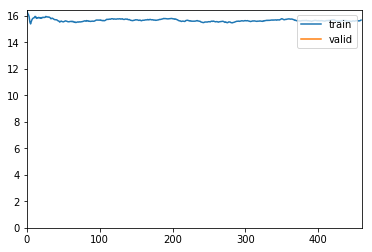

Loaded SeResNext_HEPG2_0


epoch,train_loss,valid_loss,accuracy,time
1,15.215586,15.207768,0.459355,10:57
2,14.920017,15.755810,0.394839,10:55
3,14.431163,15.343102,0.443871,10:57
4,13.786329,15.994952,0.363871,10:55
5,12.885722,14.646351,0.449032,10:57
6,11.906466,14.043713,0.476129,10:59
7,11.156410,13.651104,0.520000,10:58
8,10.651151,13.474222,0.520000,10:56
9,10.376499,13.722119,0.508387,10:55


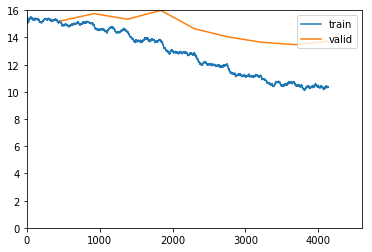


CURRENT CATEGORY: HUVEC
----------------------------------------
last_linear is unfrozen


epoch,train_loss,valid_loss,accuracy,time
0,7.361227,5.786566,0.851244,19:25


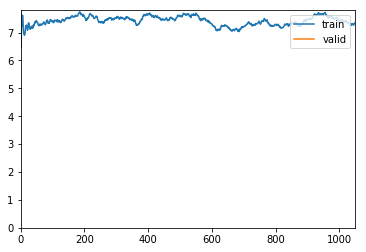

Loaded SeResNext_HUVEC_0


epoch,train_loss,valid_loss,accuracy,time
1,7.831626,5.948378,0.841629,24:12
2,8.287343,6.712706,0.787330,24:15
3,8.336036,6.952856,0.771493,24:20
4,7.588154,6.218006,0.804864,24:14
5,6.329955,6.340585,0.792421,24:21
6,5.708681,5.394986,0.835973,24:19
7,4.921916,5.282659,0.835407,24:25


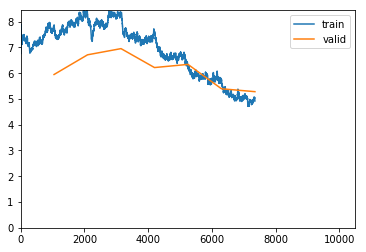

In [ ]:
categories = df['category'].unique()
best_epoch = 15

for category in categories:
    category_df = df[df['category'] == category]
    train_df_site1 = generate_df(category_df, site=1)
    train_df_site2 = generate_df(category_df, site=2)
    proc_train_df = train_df_site1.append(train_df_site2)
    
    data = (MultiChannelImageList.from_df(df=proc_train_df,path='{}train/'.format(config['PATH_DATA']))
            .split_by_rand_pct(config['VAL_SIZE'])
            .label_from_df()
            .transform(get_transforms(do_flip=False), size=512)
            .databunch(bs=config['BATCH_SIZE'], num_workers=64)
            .normalize(stats)
           )

    print('\n' + '=' * 40)
    print("CURRENT CATEGORY:", category)
    print('-' * 40)

    # LOAD MODEL
    model = seresnext(num_classes=config['CLASSES'], pretrained=False, use_bn=config['USE_BN'], use_angular=config['USE_ANGULAR'])
    model.to(config['DEVICE'])
    model.train()
    
    # freezing
    for name, child in model.named_children():
        if name == 'last_linear':
            print(name + ' is unfrozen')
            for param in child.parameters():
                param.requires_grad = True
        else:
            for param in child.parameters():
                param.requires_grad = False
    
    criterion = AMSoftmaxLoss(margin_type='cos', gamma=2., m=0.5, s=30, t=1.)

    learn = Learner(data=data,
                    model=model,
                    opt_func=RAdam,
                    loss_func=criterion,
                    metrics=[fastai.metrics.accuracy],
                    callback_fns=ShowGraph)  # .to_fp16()

    learn.model = nn.DataParallel(learn.model)
    learn.load('{0}{1}/models/{1}_{2}'.format(config['PATH_WEIGHTS'], config['MODEL_NAME'], best_epoch))
    learn.path = Path('{0}_{1}'.format(config['MODEL_NAME'], category)) 
    checkpoint_callback = SaveModelCallback(learn, name='{0}_{1}'.format(config['MODEL_NAME'], category),
                                            every='epoch', monitor='valid_loss')
    learn.fit_one_cycle(
        config['TURN_OFF_ON_N_EPOCHS'],
        max_lr=1e-4,
        wd=1e-4,
        callbacks=[checkpoint_callback],
    )

    del learn
    gc.collect()
    torch.cuda.empty_cache()

    # LOAD MODEL
    model = seresnext(num_classes=config['CLASSES'], pretrained=False, use_bn=config['USE_BN'], use_angular=config['USE_ANGULAR'])
    model.to(config['DEVICE'])
    model.train()
    
    # unfreezing
    for name, child in model.named_children():
        for param in child.parameters():
            param.requires_grad = True
    
    criterion = AMSoftmaxLoss(margin_type='cos', gamma=2., m=0.5, s=30, t=1.)

    learn = Learner(data=data,
                    model=model,
                    opt_func=RAdam,
                    loss_func=criterion,
                    metrics=[fastai.metrics.accuracy],
                    callback_fns=ShowGraph)  # .to_fp16()

    learn.model = nn.DataParallel(learn.model)
    learn.load('{0}{1}_{2}/models/{1}_{2}_0'.format(config['PATH_WEIGHTS'], config['MODEL_NAME'], category))
    learn.path = Path('{0}_{1}'.format(config['MODEL_NAME'], category)) 
    checkpoint_callback = SaveModelCallback(learn, name='{0}_{1}'.format(config['MODEL_NAME'], category),
                                            every='epoch', monitor='valid_loss')
    learn.unfreeze()
    learn.fit_one_cycle(
        10,
        max_lr=1e-4,
        wd=1e-4,
        callbacks=[checkpoint_callback],
        start_epoch=config['TURN_OFF_ON_N_EPOCHS'],
    )

after reboot notebook


CURRENT CATEGORY: RPE
----------------------------------------
last_linear is unfrozen


epoch,train_loss,valid_loss,accuracy,time
0,12.823612,11.488186,0.656774,10:04


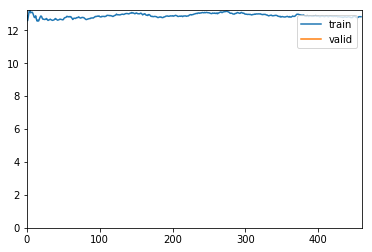

Loaded SeResNext_RPE_0


epoch,train_loss,valid_loss,accuracy,time
1,12.445317,11.191140,0.689032,11:11
2,12.567170,11.147356,0.670968,11:13
3,11.953716,11.561272,0.637419,11:14
4,10.846886,11.356885,0.624516,11:13
5,9.956311,10.601955,0.654194,11:13
6,8.931400,9.838839,0.699355,11:15
7,8.278103,9.522904,0.707097,11:18
8,7.717646,9.405864,0.710968,11:18
9,7.725679,9.246017,0.717419,11:17


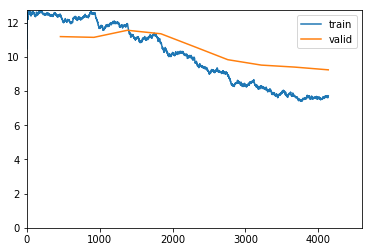


CURRENT CATEGORY: U2OS
----------------------------------------
last_linear is unfrozen


epoch,train_loss,valid_loss,accuracy,time
0,17.891972,16.876196,0.325301,04:35


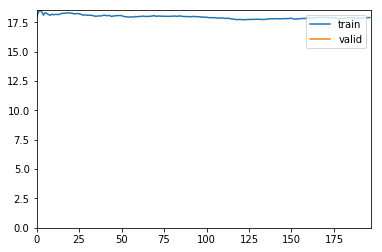

Loaded SeResNext_U2OS_0


epoch,train_loss,valid_loss,accuracy,time
1,17.065233,15.973178,0.430723,05:19
2,16.519506,15.969664,0.436747,05:15
3,15.965041,15.762947,0.448795,05:15
4,15.173866,15.836594,0.412651,05:17
5,14.308113,15.698045,0.424699,05:17
6,13.616033,15.223158,0.454819,05:17
7,12.923342,15.150646,0.451807,05:15
8,12.576167,15.235222,0.433735,05:16
9,12.420227,15.231494,0.445783,05:15


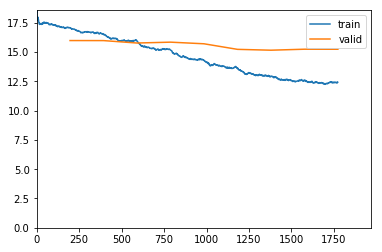

In [11]:
categories = df['category'].unique()
best_epoch = 15

for category in categories:
    if category not in ['HEPG2', 'HUVEC']:
        category_df = df[df['category'] == category]
        train_df_site1 = generate_df(category_df, site=1)
        train_df_site2 = generate_df(category_df, site=2)
        proc_train_df = train_df_site1.append(train_df_site2)

        data = (MultiChannelImageList.from_df(df=proc_train_df,path='{}train/'.format(config['PATH_DATA']))
                .split_by_rand_pct(config['VAL_SIZE'])
                .label_from_df()
                .transform(get_transforms(do_flip=False), size=512)
                .databunch(bs=config['BATCH_SIZE'], num_workers=64)
                .normalize(stats)
               )

        print('\n' + '=' * 40)
        print("CURRENT CATEGORY:", category)
        print('-' * 40)

        # LOAD MODEL
        model = seresnext(num_classes=config['CLASSES'], pretrained=False, use_bn=config['USE_BN'], use_angular=config['USE_ANGULAR'])
        model.to(config['DEVICE'])
        model.train()

        # freezing
        for name, child in model.named_children():
            if name == 'last_linear':
                print(name + ' is unfrozen')
                for param in child.parameters():
                    param.requires_grad = True
            else:
                for param in child.parameters():
                    param.requires_grad = False

        criterion = AMSoftmaxLoss(margin_type='cos', gamma=2., m=0.5, s=30, t=1.)

        learn = Learner(data=data,
                        model=model,
                        opt_func=RAdam,
                        loss_func=criterion,
                        metrics=[fastai.metrics.accuracy],
                        callback_fns=ShowGraph)  # .to_fp16()

        learn.model = nn.DataParallel(learn.model)
        learn.load('{0}{1}/models/{1}_{2}'.format(config['PATH_WEIGHTS'], config['MODEL_NAME'], best_epoch))
        learn.path = Path('{0}_{1}'.format(config['MODEL_NAME'], category)) 
        checkpoint_callback = SaveModelCallback(learn, name='{0}_{1}'.format(config['MODEL_NAME'], category),
                                                every='epoch', monitor='valid_loss')
        learn.fit_one_cycle(
            config['TURN_OFF_ON_N_EPOCHS'],
            max_lr=1e-4,
            wd=1e-4,
            callbacks=[checkpoint_callback],
        )

        del learn
        gc.collect()
        torch.cuda.empty_cache()

        # LOAD MODEL
        model = seresnext(num_classes=config['CLASSES'], pretrained=False, use_bn=config['USE_BN'], use_angular=config['USE_ANGULAR'])
        model.to(config['DEVICE'])
        model.train()

        # unfreezing
        for name, child in model.named_children():
            for param in child.parameters():
                param.requires_grad = True

        criterion = AMSoftmaxLoss(margin_type='cos', gamma=2., m=0.5, s=30, t=1.)

        learn = Learner(data=data,
                        model=model,
                        opt_func=RAdam,
                        loss_func=criterion,
                        metrics=[fastai.metrics.accuracy],
                        callback_fns=ShowGraph)  # .to_fp16()

        learn.model = nn.DataParallel(learn.model)
        learn.load('{0}{1}_{2}/models/{1}_{2}_0'.format(config['PATH_WEIGHTS'], config['MODEL_NAME'], category))
        learn.path = Path('{0}_{1}'.format(config['MODEL_NAME'], category)) 
        checkpoint_callback = SaveModelCallback(learn, name='{0}_{1}'.format(config['MODEL_NAME'], category),
                                                every='epoch', monitor='valid_loss')
        learn.unfreeze()
        learn.fit_one_cycle(
            10,
            max_lr=1e-4,
            wd=1e-4,
            callbacks=[checkpoint_callback],
            start_epoch=config['TURN_OFF_ON_N_EPOCHS'],
        )

HEPG2 finetuning


CURRENT CATEGORY: HEPG2
----------------------------------------
Loaded SeResNext_HEPG2_8


epoch,train_loss,valid_loss,accuracy,time
9,12.613284,15.614066,0.392258,12:01
10,11.584652,15.444372,0.396129,11:31
11,11.006975,14.897854,0.429677,11:27
12,10.096045,14.231387,0.451613,11:29
13,9.575453,13.521658,0.507097,11:30
14,8.908266,14.476613,0.442581,11:31
15,8.150425,13.291822,0.509677,11:31
16,7.850404,13.223144,0.523871,11:27
17,7.304422,13.415399,0.499355,11:30
18,7.071350,14.046514,0.456774,11:26


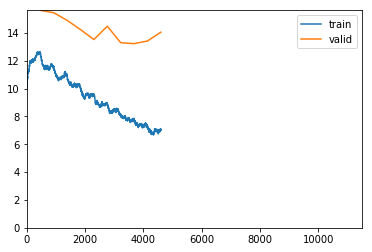

In [ ]:
categories = df['category'].unique()

for category in categories:
    if category == 'HEPG2':
        best_epoch = 8
    
        print('\n' + '=' * 40)
        print("CURRENT CATEGORY:", category)
        print('-' * 40)

        # DATA    
        category_df = df[df['category'] == category]
        train_df_site1, train_df_site2 = generate_df(category_df, site=1), generate_df(category_df, site=2)
        proc_train_df = train_df_site1.append(train_df_site2)
        cat_test_df = df_test[df_test['category'] == category].copy()

        data = (MultiChannelImageList.from_df(df=proc_train_df,path='{}train/'.format(config['PATH_DATA']))
                .split_by_rand_pct(config['VAL_SIZE'])
                .label_from_df()
                .transform(get_transforms(do_flip=False), size=512)
                .databunch(bs=config['BATCH_SIZE'], num_workers=64)
                .normalize(stats)
               )

        # MODEL
        model = seresnext(num_classes=config['CLASSES'], pretrained=False, use_bn=config['USE_BN'], use_angular=config['USE_ANGULAR'])
        model.to(config['DEVICE'])

        criterion = AMSoftmaxLoss(margin_type='cos', gamma=2., m=0.5, s=30, t=1.)

        learn = Learner(data=data,
                        model=model,
                        opt_func=RAdam,
                        loss_func=criterion,
                        metrics=[fastai.metrics.accuracy],
                        callback_fns=ShowGraph)  # .to_fp16()

        learn.model = nn.DataParallel(learn.model)
        learn.load('{0}{1}_{2}/models/{1}_{2}_{3}'.format(config['PATH_WEIGHTS'], config['MODEL_NAME'], category, best_epoch))
        learn.path = Path('{0}_{1}'.format(config['MODEL_NAME'], category))
        learn.unfreeze() 
        checkpoint_callback = SaveModelCallback(learn, name='{0}_{1}'.format(config['MODEL_NAME'], category),
                                                every='epoch', monitor='valid_loss')
        learn.fit_one_cycle(
            25,
            max_lr=1e-4,
            wd=1e-4,
            callbacks=[checkpoint_callback],
            start_epoch=best_epoch+1
        )

        del learn
        gc.collect()
        torch.cuda.empty_cache()

## Inference

In [12]:
categories = df['category'].unique()
output_df = []
output_predicted = []

for category in categories:
    if category == 'HEPG2':
        best_epoch = 16
    if category == 'HUVEC':
        best_epoch = 7
    if category == 'RPE':
        best_epoch = 9
    if category == 'U2OS':
        best_epoch = 7
    
    print('\n' + '=' * 40)
    print("CURRENT CATEGORY:", category)
    print('-' * 40)
    
    # DATA    
    category_df = df[df['category'] == category]
    train_df_site1, train_df_site2 = generate_df(category_df, site=1), generate_df(category_df, site=2)
    proc_train_df = train_df_site1.append(train_df_site2)
    cat_test_df = df_test[df_test['category'] == category].copy()
    
    data = (MultiChannelImageList.from_df(df=proc_train_df,path='{}train/'.format(config['PATH_DATA']))
            .split_by_rand_pct(config['VAL_SIZE'])
            .label_from_df()
            .transform(get_transforms(do_flip=False), size=512)
            .databunch(bs=config['BATCH_SIZE'], num_workers=64)
            .normalize(stats)
           )

    # MODEL
    model = seresnext(num_classes=config['CLASSES'], pretrained=False, use_bn=config['USE_BN'], use_angular=config['USE_ANGULAR'])
    model.to(config['DEVICE'])
    
    criterion = AMSoftmaxLoss(margin_type='cos', gamma=2., m=0.5, s=30, t=1.)

    learn = Learner(data=data,
                    model=model,
                    opt_func=RAdam,
                    loss_func=criterion,
                    metrics=[fastai.metrics.accuracy],
                    callback_fns=ShowGraph)  # .to_fp16()

    learn.model = nn.DataParallel(learn.model)
    learn.load('{0}{1}_{2}/models/{1}_{2}_{3}'.format(config['PATH_WEIGHTS'], config['MODEL_NAME'], category, best_epoch))
    learn.path = Path('{0}_{1}'.format(config['MODEL_NAME'], category))
    learn.unfreeze()
    
    # PREDICTION
    test_df_site1 = generate_df(cat_test_df, site=1)
    data_test = MultiChannelImageList.from_df(df=test_df_site1, path=config['PATH_DATA']+'test/')
    learn.data.add_test(data_test)
    preds_site1, _ = learn.get_preds(DatasetType.Test)

    test_df_site2 = generate_df(cat_test_df, site=2)
    data_test = MultiChannelImageList.from_df(df=test_df_site2, path=config['PATH_DATA']+'test/')
    learn.data.add_test(data_test)
    preds_site2, _ = learn.get_preds(DatasetType.Test)
    
    preds = 0.5*(preds_site1.numpy() + preds_site2.numpy())
    cat_test_df['sirna'] = np.argmax(preds, axis=1).astype(int)
    output_df.append(cat_test_df)
    output_predicted.append(preds)
    
    del learn
    gc.collect()
    torch.cuda.empty_cache()

In [13]:
output_df = pd.concat(output_df)
submission = output_df[['id_code', 'sirna']]
submission.to_csv('submits/{}_each_exps_best_epoch_by_loss_lr{}.csv'.format(config['MODEL_NAME'], config['LR_STR']),
                  index=False, columns=['id_code','sirna'])

In [14]:
len(submission.sirna.unique())

1096

In [15]:
submission.head()

,id_code,sirna
0,HEPG2-08_1_B03,855
1,HEPG2-08_1_B04,123
2,HEPG2-08_1_B05,836
3,HEPG2-08_1_B06,648
4,HEPG2-08_1_B07,585


## Use plates leak

In [16]:
output_predicted = np.concatenate(output_predicted)
np.save('predictions/{}_each_exps_best_epoch_by_loss_lr{}'.format(config['MODEL_NAME'], config['LR_STR']),
        output_predicted)

In [38]:
plate_groups = np.zeros((1108,4), int)
for sirna in range(1108):
    grp = df.loc[df.sirna==sirna,:].plate.value_counts().index.values
    assert len(grp) == 3
    plate_groups[sirna,0:3] = grp
    plate_groups[sirna,3] = 10 - grp.sum()
    
print(plate_groups[:10,:])

[[4 2 3 1]
 [1 3 4 2]
 [2 4 1 3]
 [1 3 4 2]
 [3 1 2 4]
 [1 3 4 2]
 [1 3 4 2]
 [2 4 1 3]
 [1 3 4 2]
 [4 2 3 1]]


In [39]:
all_test_exp = df_test.experiment.unique()

group_plate_probs = np.zeros((len(all_test_exp),4))
for idx in range(len(all_test_exp)):
    preds = output_df.loc[output_df.experiment == all_test_exp[idx],'sirna'].values
    pp_mult = np.zeros((len(preds),1108))
    pp_mult[range(len(preds)),preds] = 1
    
    sub_test = output_df.loc[output_df.experiment == all_test_exp[idx],:]
    assert len(pp_mult) == len(sub_test)
    
    for j in range(4):
        mask = np.repeat(plate_groups[np.newaxis, :, j], len(pp_mult), axis=0) == \
               np.repeat(sub_test.plate.values[:, np.newaxis], 1108, axis=1)
        
        group_plate_probs[idx,j] = np.array(pp_mult)[mask].sum()/len(pp_mult)

In [40]:
exp_to_group = group_plate_probs.argmax(1)
print(exp_to_group)

[3 1 0 0 0 0 2 2 3 0 0 3 1 0 0 0 0 3]


In [41]:
# this is the function that sets 75% of the sirnas to zero according to the selected assignment

def select_plate_group(pp_mult, idx):
    sub_test = output_df.loc[output_df.experiment == all_test_exp[idx],:]
    assert len(pp_mult) == len(sub_test)
    mask = np.repeat(plate_groups[np.newaxis, :, exp_to_group[idx]], len(pp_mult), axis=0) != \
           np.repeat(sub_test.plate.values[:, np.newaxis], 1108, axis=1)
    pp_mult[mask] = 0
    return pp_mult

In [42]:
sub = submission.copy()

for idx in range(len(all_test_exp)):
    indices = (output_df.experiment == all_test_exp[idx])
    preds = output_predicted[indices, :].copy()
    
    preds = select_plate_group(preds, idx)
    sub.loc[indices,'sirna'] = preds.argmax(1)

In [43]:
sub.to_csv('submits/{}_each_exps_best_epoch_by_loss_lr{}_plates_leak.csv'.format(config['MODEL_NAME'], config['LR_STR']),
           index=False, columns=['id_code','sirna'])

In [44]:
print((sub.sirna == submission.sirna).mean())

0.6666331607780067


In [45]:
len(submission.sirna.unique()), len(sub.sirna.unique())

(1090, 1105)

In [46]:
sub.head()

,id_code,sirna
0,HEPG2-08_1_B03,855
1,HEPG2-08_1_B04,892
2,HEPG2-08_1_B05,836
3,HEPG2-08_1_B06,249
4,HEPG2-08_1_B07,878
